# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.ticker import PercentFormatter

px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from sklearn import __version__ as sklearn_version
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, MinMaxScaler, Normalizer,
                                   StandardScaler, normalize, scale)

# Grains

## Data

In [5]:
df = pd.read_csv('datasets/grains/seeds.csv', header=None)
varieties = pd.read_csv('datasets/grains/varieties.csv', header=None)
assert df.shape[0] == varieties.shape[0], "Data size mismatch"

In [6]:
print(df.shape)
df.sample(10)

(210, 8)


,0,1,2,3,4,5,6,7
54,14.52,14.60,0.8557,5.741,3.113,1.481,5.487,1
131,18.94,16.32,0.8942,6.144,3.825,2.908,5.949,2
113,19.14,16.61,0.8722,6.259,3.737,6.682,6.053,2
157,12.13,13.73,0.8081,5.394,2.745,4.825,5.220,3
55,15.03,14.77,0.8658,5.702,3.212,1.933,5.439,1
48,14.79,14.52,0.8819,5.545,3.291,2.704,5.111,1
27,12.74,13.67,0.8564,5.395,2.956,2.504,4.869,1
134,15.56,14.89,0.8823,5.776,3.408,4.972,5.847,2
85,18.27,16.09,0.8870,6.173,3.651,2.443,6.197,2
80,16.53,15.34,0.8823,5.875,3.467,5.532,5.880,2


In [7]:
print(varieties.shape)
varieties.sample(10)

(210, 1)


,0
168,Canadian_wheat
69,Kama_wheat
99,Rosa_wheat
36,Kama_wheat
126,Rosa_wheat
39,Kama_wheat
120,Rosa_wheat
103,Rosa_wheat
104,Rosa_wheat
84,Rosa_wheat


In [8]:
# reverse engineered:
#   variety -> 7
#   width   -> 4
#   length  -> 3
variety_numbers = df[7]
grains = df[[4, 3]].to_numpy()
samples = df.drop(7, axis=1).to_numpy()
varieties = varieties[0].to_list()

## KMeans Clustering

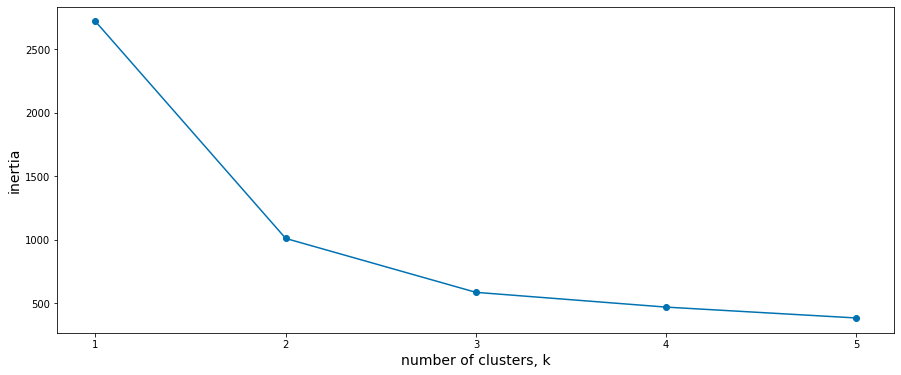

In [9]:
# How many clusters? Elbow of inertia
ks = range(1, 6)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(samples)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [10]:
# Create a KMeans model with 3 clusters: model
model = KMeans(n_clusters=3)

# Use fit_predict to fit model and obtain cluster labels: labels
labels = model.fit_predict(samples)

# Create a DataFrame with clusters and varieties as columns: df
df = pd.DataFrame({'labels': labels, 'varieties': varieties})

# Create crosstab: ct
ct = pd.crosstab(df['labels'], df['varieties'])

# Display ct
print(ct)

varieties  Canadian_wheat  Kama_wheat  Rosa_wheat
labels                                           
0                      68           9           0
1                       0           1          60
2                       2          60          10


## Hierarchical Clustering

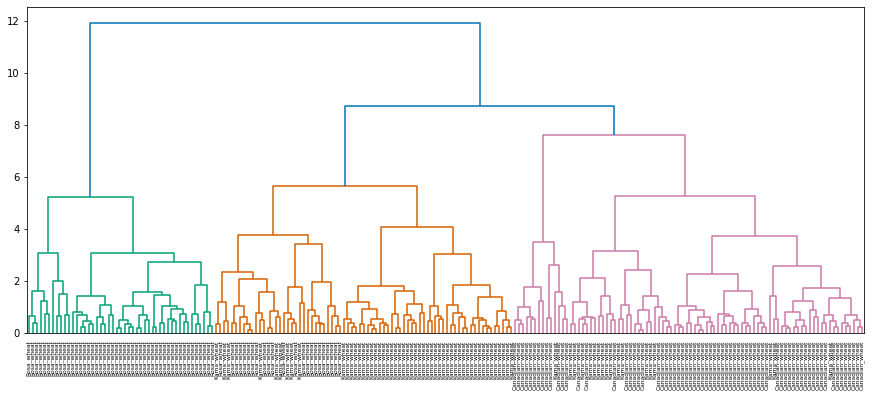

In [11]:
# Calculate the linkage: mergings
mergings = sp.cluster.hierarchy.linkage(samples, method='complete')

# Plot the dendrogram, using varieties as labels
sp.cluster.hierarchy.dendrogram(
    mergings,
    labels=varieties,
    leaf_rotation=90,
    leaf_font_size=6,
)
plt.show()

In [12]:
# Use fcluster to extract labels: labels
labels = sp.cluster.hierarchy.fcluster(mergings, 6, criterion='distance')

# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'labels': labels, 'varieties': varieties})

# Create crosstab: ct
ct = pd.crosstab(df.labels, df.varieties)

# Display ct
print(ct)

varieties  Canadian_wheat  Kama_wheat  Rosa_wheat
labels                                           
1                       0           0          47
2                       0          52          23
3                      13           1           0
4                      57          17           0


## t-distributed Stochastic Neighbor Embedding (t-SNE)

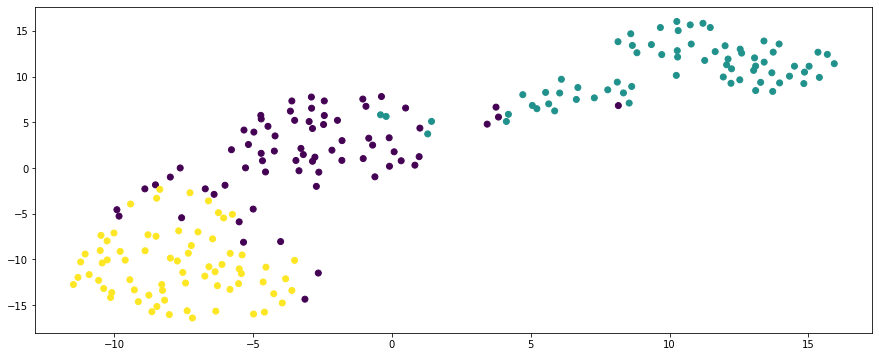

In [13]:
# Create a TSNE instance: model
model = TSNE(learning_rate=200)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(samples)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
plt.scatter(xs, ys, c=variety_numbers)
plt.show()

## PCA

Raw R2: 0.8604149377143469
PCA R2: 8.935982743022041e-17


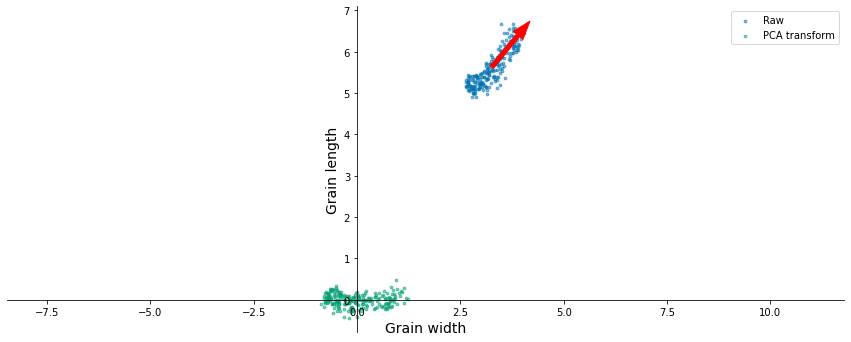

In [14]:
# Assign the 0th column of grains: width
width = grains[:, 0]
length = grains[:, 1]

# Create PCA instance: model
model = PCA()
pca_features = model.fit_transform(grains)
xs = pca_features[:,0]
ys = pca_features[:,1]

# Get the mean of the grain samples: mean
model_mean = model.mean_
first_pc = model.components_[0, :]

# Scatter plot xs vs ys
fig, ax = plt.subplots()
plt.scatter(width, length, label="Raw", alpha=0.5, s=8)
plt.scatter(xs, ys, label="PCA transform", alpha=0.5, s=8)
plt.arrow(model_mean[0], model_mean[1], first_pc[0], first_pc[1], color='red', width=0.1)
plt.xlabel('Grain width')
plt.ylabel('Grain length')
plt.legend()
plt.axis('equal')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

# Calculate the Pearson correlation
correlation, pvalue = sp.stats.pearsonr(width, length)
pca_correlation, pvalue = sp.stats.pearsonr(xs, ys)
print("Raw R2:", correlation)
print("PCA R2:", pca_correlation)

# Wines

In [15]:
## Data

In [16]:
df = pd.read_csv('datasets/wine.csv')

In [17]:
df.sample(10)

,class_label,class_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
96,2,Grignolino,11.81,2.12,2.74,21.5,134,1.60,0.99,0.14,1.56,2.50,0.95,2.26,625
140,3,Barbera,12.93,2.81,2.70,21.0,96,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600
91,2,Grignolino,12.00,1.51,2.42,22.0,86,1.45,1.25,0.50,1.63,3.60,1.05,2.65,450
98,2,Grignolino,12.37,1.07,2.10,18.5,88,3.52,3.75,0.24,1.95,4.50,1.04,2.77,660
136,3,Barbera,12.25,4.72,2.54,21.0,89,1.38,0.47,0.53,0.80,3.85,0.75,1.27,720
5,1,Barolo,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
173,3,Barbera,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
71,2,Grignolino,13.86,1.51,2.67,25.0,86,2.95,2.86,0.21,1.87,3.38,1.36,3.16,410
116,2,Grignolino,11.82,1.47,1.99,20.8,86,1.98,1.60,0.30,1.53,1.95,0.95,3.33,495
8,1,Barolo,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045


## Scale

In [18]:
df.agg(np.var)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/apply.py:169: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return getattr(obj, f)()


class_label                 0.600679
alcohol                     0.659062
malic_acid                  1.248015
ash                         0.075265
alcalinity_of_ash          11.152686
magnesium                 203.989335
total_phenols               0.391690
flavanoids                  0.997719
nonflavanoid_phenols        0.015489
proanthocyanins             0.327595
color_intensity             5.374449
hue                         0.052245
od280                       0.504086
proline                 99166.717355
dtype: float64

<AxesSubplot:>

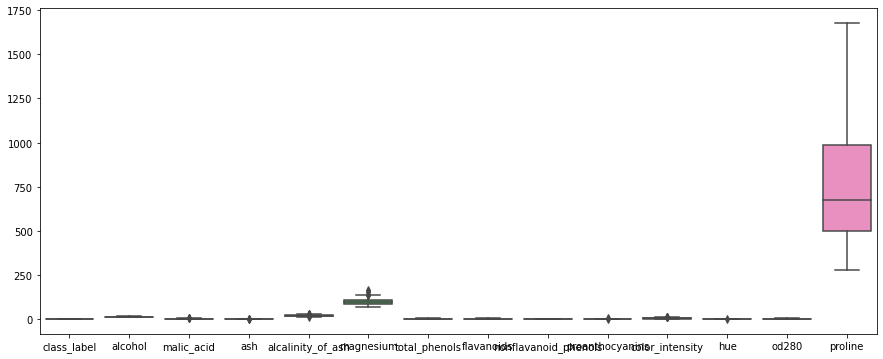

In [19]:
sns.boxplot(data=df)

In [20]:
samples = df.drop(["class_label", "class_name"], axis=1).to_numpy()

<AxesSubplot:>

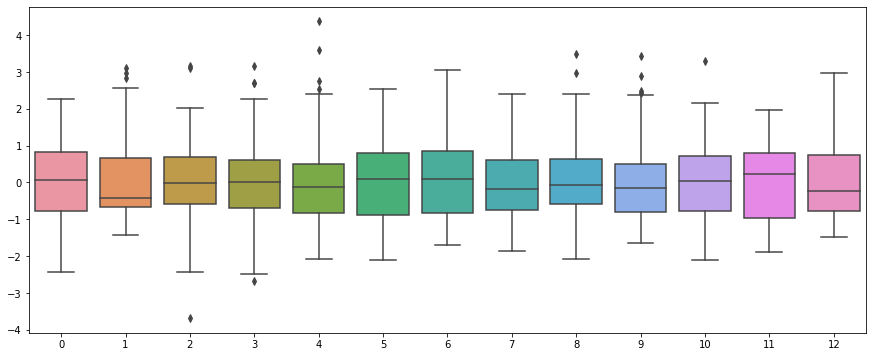

In [21]:
scaler = StandardScaler()
sns.boxplot(data=scaler.fit_transform(samples))

## KMeans Clustering

In [22]:
# build steps
scalar = StandardScaler()
model = KMeans()
pipeline = make_pipeline(scaler, model)

In [23]:
pipeline.fit(samples)

Pipeline(steps=[('standardscaler', StandardScaler()), ('kmeans', KMeans())])

In [24]:
# Setup the hyperparameter grid
k_space = [x for x in range(1, 15)]
param_grid = {f'{pipeline.steps[1][0]}__n_clusters': k_space}

# Instantiate the GridSearchCV object: logreg_cv
cv = KFold(n_splits=5)
model_cv = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

# Fit it to the data
model_cv.fit(samples)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(
    model_cv.best_params_))
print("Best score: {}".format(model_cv.best_score_))

Tuned Parameters: {'kmeans__n_clusters': 14}
Best score: -284.9366864554969


# Fish

## Data

In [25]:
df = pd.read_csv('datasets/fish.csv', header=None)

In [26]:
df.sample(10)

,0,1,2,3,4,5,6
16,Bream,700.0,30.4,33.0,38.5,38.8,13.5
66,Smelt,19.7,13.2,14.3,15.2,18.9,13.6
37,Roach,87.0,18.2,19.8,22.2,25.3,14.3
84,Pike,1650.0,59.0,63.4,68.0,15.9,11.0
35,Roach,69.0,16.5,18.2,20.3,26.1,13.9
53,Roach,390.0,29.5,31.7,35.0,27.1,15.3
67,Smelt,19.9,13.8,15.0,16.2,18.1,11.6
22,Bream,680.0,31.8,35.0,40.6,38.1,15.1
49,Roach,200.0,22.1,23.5,26.8,27.6,15.4
74,Pike,456.0,40.0,42.5,45.5,16.0,9.5


In [27]:
species = df[0]
df.drop(0, axis=1, inplace=True)
samples = df.to_numpy()

## KMeans Clustering

In [28]:
# pipeline
scaler = StandardScaler()
model = KMeans(n_clusters=4)
pipeline = make_pipeline(scaler, model)

In [29]:
# Fit the pipeline to samples
pipeline.fit(samples)

# Calculate the cluster labels: labels
labels = pipeline.predict(samples)

# Create a DataFrame with labels and species as columns: df
df_ct = pd.DataFrame({"labels": labels, "species": species})

# Create crosstab: ct
ct = pd.crosstab(df_ct.labels, df_ct.species)

# Display ct
print(ct)

species  Bream  Pike  Roach  Smelt
labels                            
0            1     0     19      1
1           33     0      1      0
2            0    17      0      0
3            0     0      0     13


## Intrinsic Dimensions

([<matplotlib.axis.XTick at 0x7f7ebbbe49a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

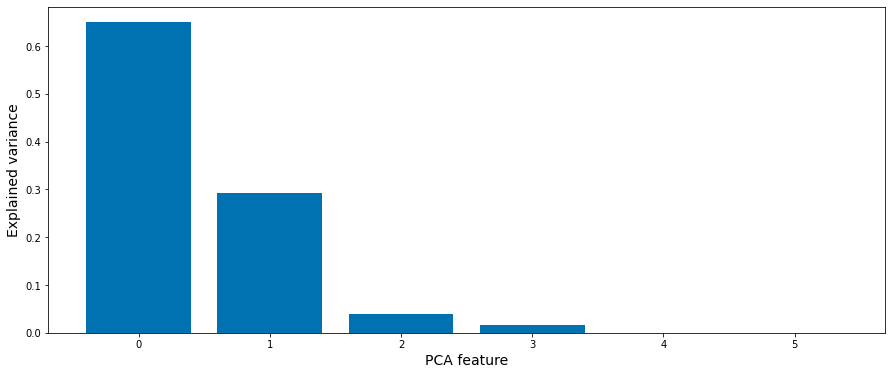

In [30]:
# Create pipeline: pipeline
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(samples)

# Plot the explained variances
features = range(0, pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Explained variance')
plt.xticks(features)

In [31]:
# component loadings or weights (correlation coefficient between original variables and the component)
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC" + str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['feature'] = df.columns.values
loadings_df = loadings_df.set_index('feature')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
feature,,,,,,
1,0.482436,-0.022969,-0.330179,0.810968,0.000248,0.006311
2,0.496622,0.120741,0.174025,-0.225946,-0.504754,0.634568
3,0.498907,0.101658,0.158914,-0.223189,-0.289235,-0.762911
4,0.503418,0.038466,0.085967,-0.264596,0.807748,0.123417
5,0.127925,-0.687801,-0.617391,-0.346926,-0.095052,0.000933
6,0.043808,-0.707113,0.668492,0.226047,0.008619,0.004274


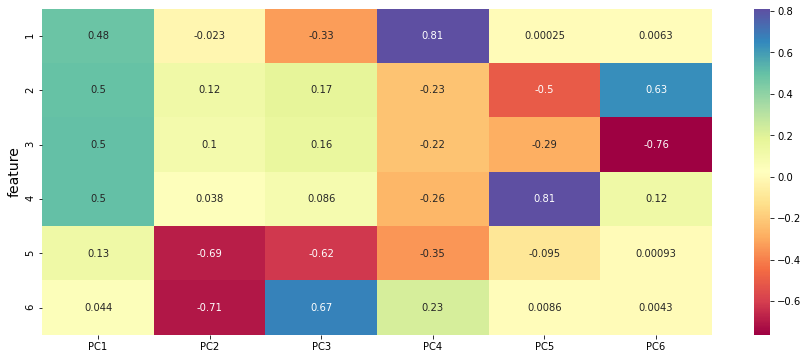

In [32]:
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')

# Stocks

## Data

In [33]:
df = pd.read_csv('datasets/company-stock-movements-2010-2015-incl.csv')

In [34]:
df.sample(10)

,Unnamed: 0,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
7,Canon,0.730000,0.369999,-0.099999,-0.169999,0.030003,0.110001,-0.079998,0.140000,0.389999,...,0.209999,0.560002,0.069999,0.119999,0.050003,-0.459999,0.259998,-0.109999,0.090001,-0.110001
45,Sony,0.500000,0.160000,-0.029999,0.059999,0.369999,-0.119999,0.100001,0.380001,0.140000,...,0.130001,0.280001,-0.260000,0.010000,0.020001,-0.149999,-0.060002,0.010000,0.010000,-0.030000
29,Lookheed Martin,0.979995,1.029999,0.410004,-1.759994,1.260003,0.209999,0.209999,0.719993,0.049995,...,1.199997,1.790001,-0.710007,-3.599991,0.460007,1.979996,0.599991,1.589996,-0.529999,0.260010
43,SAP,-0.119999,-0.160000,0.579998,0.529999,0.530003,0.239997,-0.030003,-0.209999,-1.080002,...,0.580002,0.069999,1.629997,-0.939994,0.800003,0.200005,-0.340004,-0.360001,-0.229996,-0.670006
39,Pfizer,0.660000,-0.260000,-0.060000,-0.109998,0.059999,0.000000,-0.029999,0.339998,0.179998,...,0.539999,0.440000,0.319999,-0.069999,0.300001,-0.050000,-0.069999,0.130001,0.289999,0.410000
37,Novartis,-1.139999,-0.050000,-0.500000,0.029999,-0.079998,0.180000,0.360000,-0.020001,0.410000,...,0.450004,0.150002,0.479996,0.490005,1.010002,0.300003,-0.310006,-0.240006,0.050003,-0.239997
8,Caterpillar,0.899997,0.700001,0.250000,0.369999,1.090000,3.179996,-0.769996,0.230004,-0.119998,...,0.209999,0.519996,1.029998,-0.020004,1.290001,-0.390000,1.209999,0.449997,-0.220001,0.159996
3,American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,...,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001
34,Mitsubishi,0.060000,0.020000,0.010000,0.040000,0.060000,-0.020000,-0.010000,0.030000,0.090000,...,0.070000,0.070000,0.020000,0.010000,-0.010000,-0.020000,0.020000,0.020000,-0.010000,0.040000
14,Dell,-0.080000,0.100000,-0.170000,0.150000,0.050000,0.000000,0.230000,-0.040000,-0.250000,...,0.009000,0.010000,-0.020000,0.010000,-0.005000,-0.005000,0.010000,-0.010000,-0.010000,0.020000


In [35]:
companies = df["Unnamed: 0"].to_list()
movements = df.drop("Unnamed: 0", axis=1).to_numpy()

## Normalize

In [36]:
# Create a normalizer: normalizer
normalizer = Normalizer()

# Create a KMeans model with 10 clusters: kmeans
kmeans = KMeans(n_clusters=10)

# Make a pipeline chaining normalizer and kmeans: pipeline
pipeline = make_pipeline(normalizer, kmeans)

# Fit pipeline to the daily price movements
pipeline.fit(movements)

Pipeline(steps=[('normalizer', Normalizer()),
                ('kmeans', KMeans(n_clusters=10))])

In [37]:
# Predict the cluster labels: labels
labels = pipeline.predict(movements)

# Create a DataFrame aligning labels and companies: df
df = pd.DataFrame({'labels': labels, 'companies': companies})

# Display df sorted by cluster label
print(df.sort_values(by=["labels"]))

    labels                           companies
29       0                     Lookheed Martin
36       0                    Northrop Grumman
19       1                     GlaxoSmithKline
52       1                            Unilever
6        1            British American Tobacco
49       1                               Total
46       1                      Sanofi-Aventis
37       1                            Novartis
43       1                                 SAP
42       1                   Royal Dutch Shell
39       1                              Pfizer
30       2                          MasterCard
32       2                                  3M
35       2                            Navistar
44       2                        Schlumberger
47       2                            Symantec
50       2  Taiwan Semiconductor Manufacturing
51       2                   Texas instruments
53       2                       Valero Energy
57       2                               Exxon
58       2   

## Hierarchical Clustering

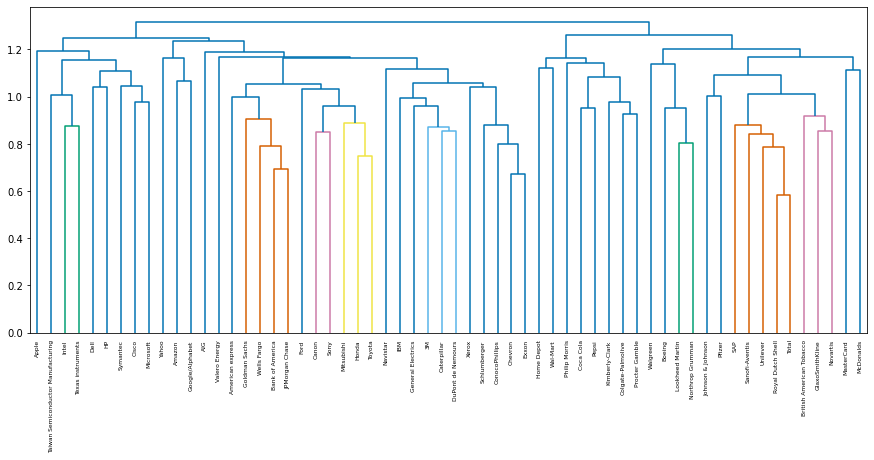

In [38]:
# Normalize the movements: normalized_movements
normalized_movements = normalize(movements)

# Calculate the linkage: mergings
mergings = sp.cluster.hierarchy.linkage(normalized_movements,
                                        method='complete')

# Plot the dendrogram
_ = sp.cluster.hierarchy.dendrogram(mergings,
                                    labels=companies,
                                    leaf_rotation=90,
                                    leaf_font_size=6)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


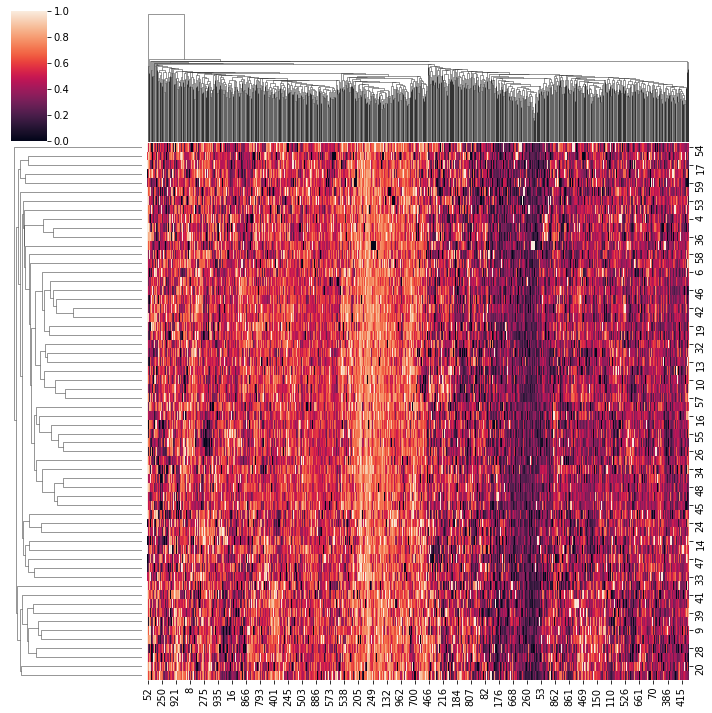

In [39]:
sns.clustermap(normalized_movements, standard_scale=1)

## t-SNE

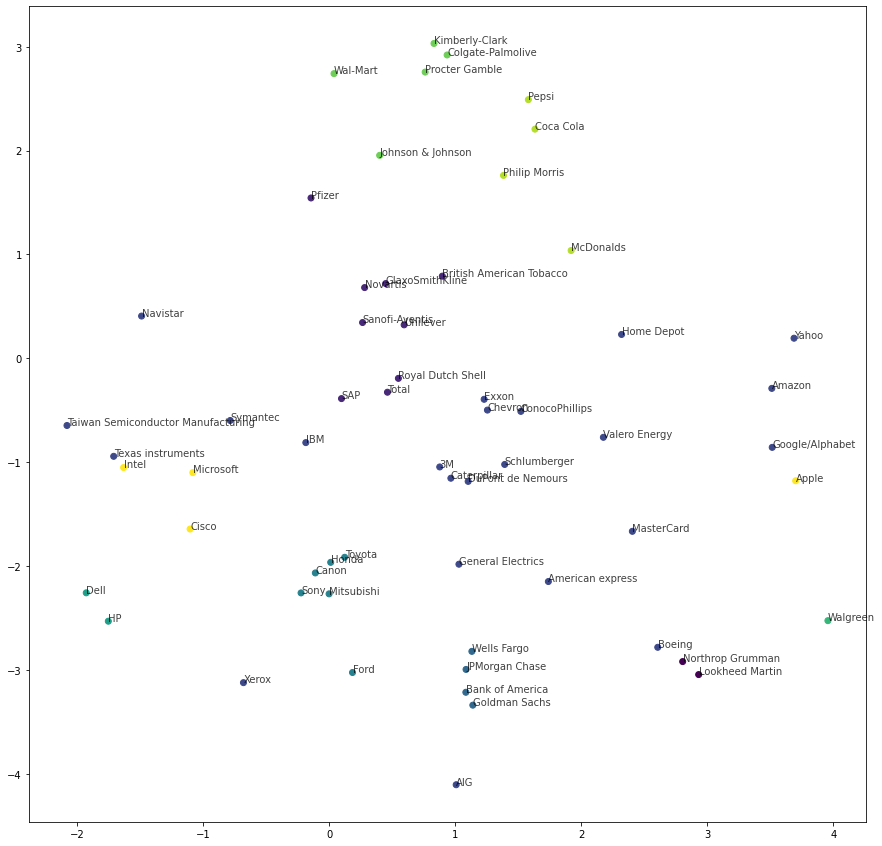

In [40]:
# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_movements)

# Select the 0th feature: xs
xs = tsne_features[:, 0]

# Select the 1th feature: ys
ys = tsne_features[:, 1]

# Scatter plot
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(xs, ys, c=labels)

# Annotate the points
for x, y, company in zip(xs, ys, companies):
    plt.annotate(company, (x, y), fontsize=10, alpha=0.75)

# Eurovision

## Data

In [41]:
df = pd.read_csv('datasets/eurovision-2016.csv')

In [42]:
df.head(10)

,From country,To country,Jury A,Jury B,Jury C,Jury D,Jury E,Jury Rank,Televote Rank,Jury Points,Televote Points
0,Albania,Belgium,20,16,24,22,24,25,14,NaN,NaN
1,Albania,Czech Republic,21,15,25,23,16,22,22,NaN,NaN
2,Albania,The Netherlands,22,14,23,24,21,24,24,NaN,NaN
3,Albania,Azerbaijan,19,12,11,21,11,13,19,NaN,NaN
4,Albania,Hungary,8,13,9,14,9,10,10,1.0,1.0
5,Albania,Italy,4,10,3,7,2,3,2,8.0,10.0
6,Albania,Israel,10,2,18,4,12,8,17,3.0,NaN
7,Albania,Bulgaria,11,3,6,13,6,7,3,4.0,8.0
8,Albania,Sweden,16,8,15,6,15,11,8,NaN,3.0
9,Albania,Germany,18,17,20,11,17,18,15,NaN,NaN


In [43]:
df.columns = [x.lower().replace(" ","_") for x in df.columns]
df.fillna(0, inplace=True)

In [44]:
df.head()

,from_country,to_country,jury_a,jury_b,jury_c,jury_d,jury_e,jury_rank,televote_rank,jury_points,televote_points
0,Albania,Belgium,20,16,24,22,24,25,14,0.0,0.0
1,Albania,Czech Republic,21,15,25,23,16,22,22,0.0,0.0
2,Albania,The Netherlands,22,14,23,24,21,24,24,0.0,0.0
3,Albania,Azerbaijan,19,12,11,21,11,13,19,0.0,0.0
4,Albania,Hungary,8,13,9,14,9,10,10,1.0,1.0


In [45]:
# reconstructing the samples used in DC tutorial
samples = df.pivot_table(index="from_country",
                         columns="to_country",
                         values="televote_points").fillna(
                             max(df.televote_points)).to_numpy()

In [46]:
country_names = df.from_country.unique()

## Hierarchical Clustering

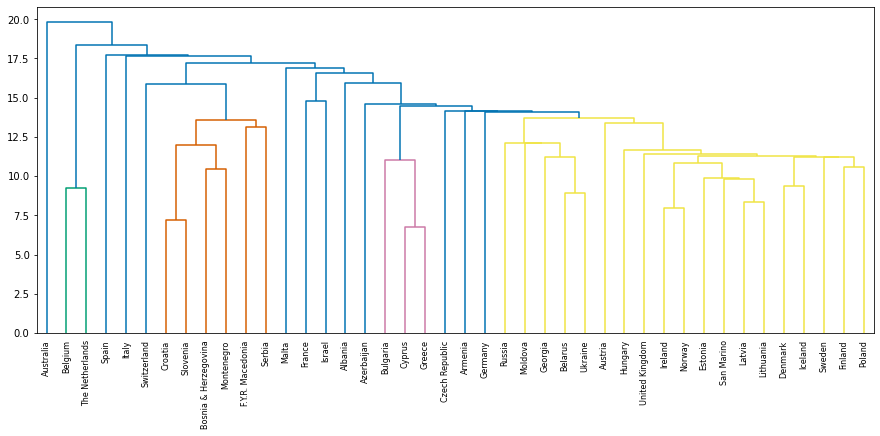

In [47]:
# Calculate the linkage: mergings
mergings = sp.cluster.hierarchy.linkage(samples, method='single')

# Plot the dendrogram
sp.cluster.hierarchy.dendrogram(mergings, labels=country_names, leaf_rotation=90)
plt.show()

# Wikipedia Articles

In [48]:
# the below data emerges from a prior analysis

# Import TfidfVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer: tfidf
#tfidf = TfidfVectorizer()

# Apply fit_transform to document: csr_mat
#csr_mat = tfidf.fit_transform(documents)

# Print result of toarray() method
#print(csr_mat.toarray())

# Get the words: words
#words = tfidf.get_feature_names()

# Print words
#print(words)

In [49]:
df = pd.read_csv('datasets/wikipedia_articles/wikipedia-vectors.csv')
df.sample(10)

,Unnamed: 0,HTTP 404,Alexa Internet,Internet Explorer,HTTP cookie,Google Search,Tumblr,Hypertext Transfer Protocol,Social search,Firefox,...,Chad Kroeger,Nate Ruess,The Wanted,Stevie Nicks,Arctic Monkeys,Black Sabbath,Skrillex,Red Hot Chili Peppers,Sepsis,Adam Levine
5478,5478,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
13045,13045,0.0,0.0,0.0,0.0,0.000000,0.04229,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.02977,0.000000,0.000000,0.000000
4847,4847,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
13072,13072,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1893,1893,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.025591,0.000000,0.000000,0.00000,0.000000,0.000000,0.014806
10104,10104,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8765,8765,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
12728,12728,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.006562,0.000000,0.010598,0.00000,0.000000,0.000000,0.000000
10673,10673,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.026584,0.000000
11544,11544,0.0,0.0,0.0,0.0,0.003901,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.010444,0.002396,0.00000,0.004979,0.012850,0.000000


In [50]:
df.columns = [x.lower().replace(" ","_") for x in df.columns]
df.drop("unnamed:_0", axis=1, inplace=True)
df.sample(10)

,http_404,alexa_internet,internet_explorer,http_cookie,google_search,tumblr,hypertext_transfer_protocol,social_search,firefox,linkedin,...,chad_kroeger,nate_ruess,the_wanted,stevie_nicks,arctic_monkeys,black_sabbath,skrillex,red_hot_chili_peppers,sepsis,adam_levine
10107,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2508,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.004937,0.0
7846,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.003437,0.004434,0.0
12573,0.0,0.000000,0.000000,0.0,0.006649,0.0,0.009221,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
8862,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.005812,0.007500,0.0
6040,0.0,0.020709,0.001923,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.009255,0.0
1640,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
10369,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.043062,0.0,0.017369,0.010189,0.0,0.0,0.000000,0.006268,0.0
10609,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
9372,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [51]:
titles = list(df.columns)
articles = sp.sparse.csr_matrix(df.values).T

In [52]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=50)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=6)

# Create a pipeline: pipeline
pipeline = make_pipeline(svd, kmeans)

In [53]:
# Fit the pipeline to articles
pipeline.fit(articles)

# Calculate the cluster labels: labels
labels = pipeline.predict(articles)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'article': titles})

# Display df sorted by cluster label
print(df.sort_values('label'))

    label                                        article
0       0                                       http_404
1       0                                 alexa_internet
2       0                              internet_explorer
3       0                                    http_cookie
4       0                                  google_search
5       0                                         tumblr
6       0                    hypertext_transfer_protocol
7       0                                  social_search
8       0                                        firefox
9       0                                       linkedin
30      1                  france_national_football_team
31      1                              cristiano_ronaldo
32      1                                   arsenal_f.c.
33      1                                 radamel_falcao
34      1                             zlatan_ibrahimović
38      1                                         neymar
36      1              2014_fif

In [54]:
# Create an NMF instance: model
model = NMF(n_components=6)

# Fit the model to articles
model.fit(articles)

# Transform the articles: nmf_features
nmf_features = model.transform(articles)

# Print the NMF features
print(nmf_features.round(2))

[[0.   0.   0.   0.   0.   0.44]
 [0.   0.   0.   0.   0.   0.57]
 [0.   0.   0.   0.   0.   0.4 ]
 [0.   0.   0.   0.   0.   0.38]
 [0.   0.   0.   0.   0.   0.49]
 [0.01 0.01 0.01 0.03 0.   0.33]
 [0.   0.   0.02 0.   0.01 0.36]
 [0.   0.   0.   0.   0.   0.49]
 [0.02 0.01 0.   0.02 0.03 0.48]
 [0.01 0.03 0.03 0.07 0.02 0.34]
 [0.   0.   0.53 0.   0.03 0.  ]
 [0.   0.   0.36 0.   0.   0.  ]
 [0.01 0.01 0.31 0.06 0.01 0.02]
 [0.   0.01 0.34 0.01 0.   0.  ]
 [0.   0.   0.43 0.   0.04 0.  ]
 [0.   0.   0.48 0.   0.   0.  ]
 [0.01 0.02 0.38 0.03 0.   0.01]
 [0.   0.   0.48 0.   0.   0.  ]
 [0.   0.01 0.55 0.   0.   0.  ]
 [0.   0.   0.47 0.   0.   0.  ]
 [0.   0.01 0.02 0.52 0.06 0.01]
 [0.   0.   0.   0.51 0.   0.  ]
 [0.   0.01 0.   0.42 0.   0.  ]
 [0.   0.   0.   0.44 0.   0.  ]
 [0.   0.   0.   0.5  0.   0.  ]
 [0.1  0.09 0.   0.38 0.   0.01]
 [0.   0.   0.   0.57 0.   0.01]
 [0.01 0.01 0.   0.47 0.   0.01]
 [0.   0.   0.   0.58 0.   0.  ]
 [0.   0.   0.   0.53 0.01 0.01]
 [0.   0.4

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [55]:
# Create a pandas DataFrame: df
df = pd.DataFrame(nmf_features, index=titles)

# Print the row for 'Anne Hathaway'
print(df[df.index == 'anne_hathaway'])

# Print the row for 'Denzel Washington'
print(df[df.index == 'denzel_washington'])

                      0    1    2         3    4    5
anne_hathaway  0.003845  0.0  0.0  0.575717  0.0  0.0
                     0         1    2         3    4    5
denzel_washington  0.0  0.005601  0.0  0.422384  0.0  0.0


In [56]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=words)

# Print the shape of the DataFrame
print(components_df.shape)

# Select row 3: component
component = components_df.iloc[3]

# Print result of nlargest
print(component.nlargest())

NameError: name 'words' is not defined

In [57]:
# Normalize the NMF features: norm_features
norm_features = normalize(nmf_features)

# Create a DataFrame: df
df = pd.DataFrame(norm_features, index=titles)

# Select the row corresponding to 'Cristiano Ronaldo': article
article = df.loc['cristiano_ronaldo']

# Compute the dot products: similarities
similarities = df.dot(article)

# Display those with the largest cosine similarity
print(similarities.nlargest())

cristiano_ronaldo                1.000000
franck_ribéry                    0.999972
radamel_falcao                   0.999942
zlatan_ibrahimović               0.999942
france_national_football_team    0.999923
dtype: float64


# LCD Digits

In [58]:
def show_as_image(sample):
    bitmap = sample.reshape((13, 8))
    plt.figure()
    plt.imshow(bitmap, cmap='gray', interpolation='nearest')
    plt.colorbar()

In [59]:
df = pd.read_csv('datasets/lcd-digits.csv', header=None)

In [60]:
samples = df.to_numpy()

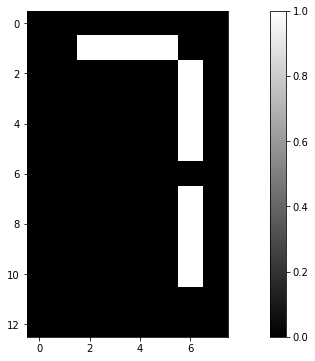

In [61]:
# Select the 0th row: digit
digit = samples[0]

# Reshape digit to a 13x8 array: bitmap
bitmap = digit.reshape(13, 8)

# Use plt.imshow to display bitmap
plt.imshow(bitmap, cmap='gray', interpolation='nearest')
plt.colorbar()

## Non-negative Matrix Factorization (NMF)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


[4.76823559e-01 0.00000000e+00 0.00000000e+00 5.90605054e-01
 4.81559442e-01 0.00000000e+00 7.37551667e-16]


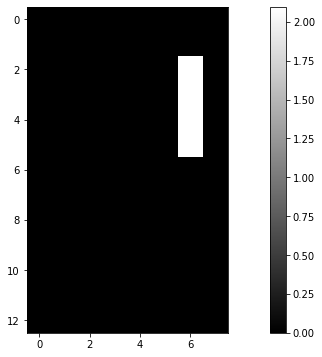

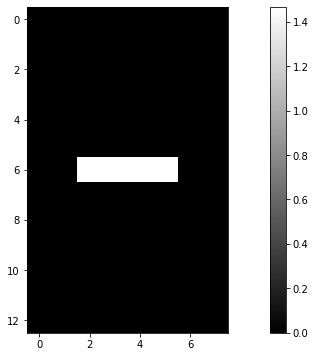

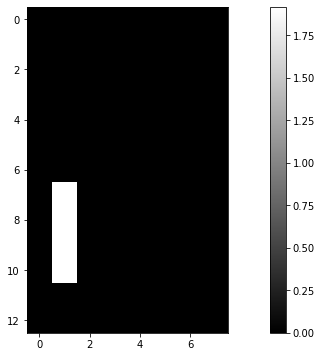

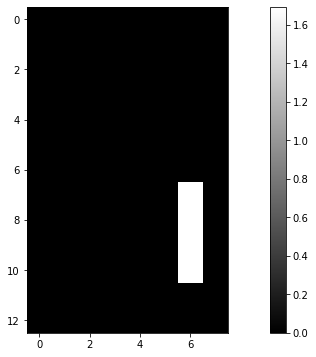

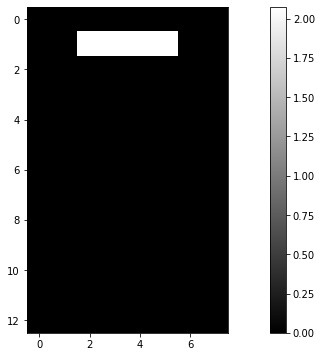

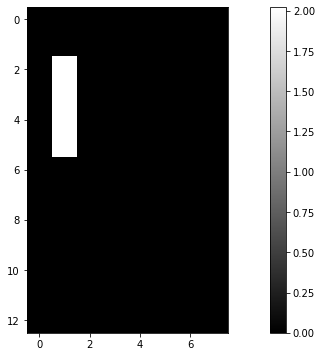

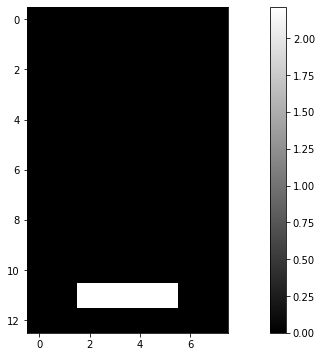

In [62]:
# Create an NMF model: model
model = NMF(n_components=7)

# Apply fit_transform to samples: features
features = model.fit_transform(samples)

# Call show_as_image on each component
for component in model.components_:
    show_as_image(component)

# Assign the 0th row of features: digit_features
digit_features = features[0]

# Print digit_features
print(digit_features)

## NMF != PCA

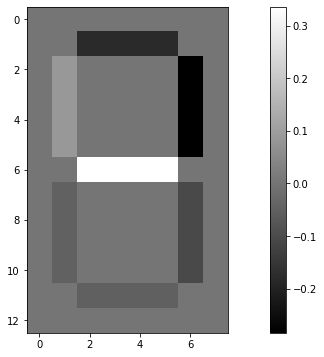

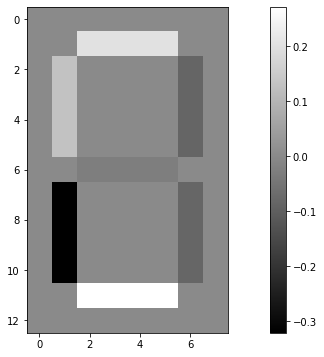

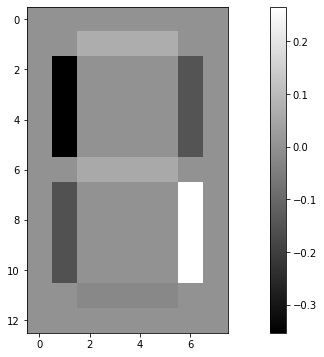

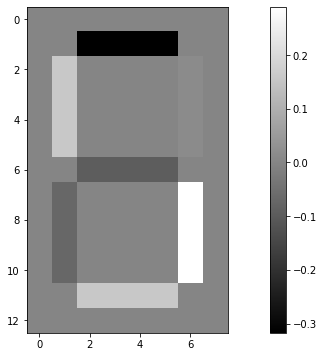

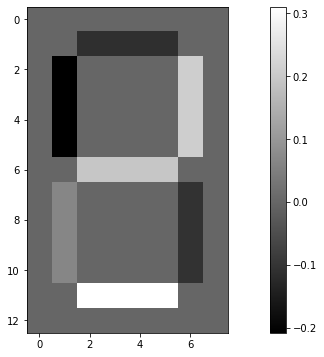

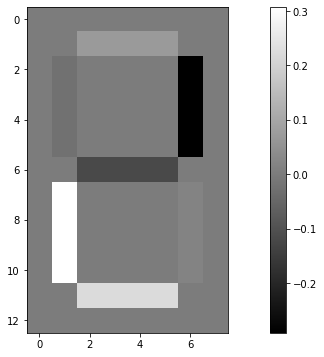

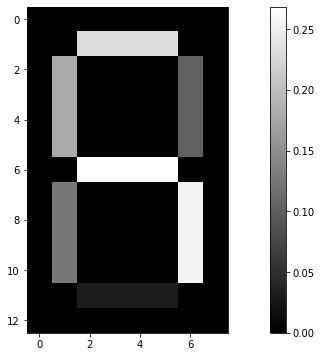

In [63]:
# NMF != PCA

# Create a PCA instance: model
model = PCA(n_components=7)

# Apply fit_transform to samples: features
features = model.fit_transform(samples)

# Call show_as_image on each component
for component in model.components_:
    show_as_image(component)    

# Musical Artists

In [64]:
df = pd.read_csv('datasets/musical_artists/scrobbler-small-sample.csv')
artist_names = pd.read_csv('datasets/musical_artists/artists.csv', header=None)
artist_names = artist_names[0].to_list()
df.sample(10)

,user_offset,artist_offset,playcount
426,56,2,152
498,67,6,148
1645,253,79,219
1072,160,103,73
838,125,66,114
50,9,12,79
2135,336,54,59
444,59,45,64
2459,398,47,69
2186,348,92,545


In [65]:
# reconstruct the sparse matrix representation
n_rows = df.artist_offset.max() + 1
n_cols = df.user_offset.max() + 1
data = np.zeros((n_rows, n_cols))
print(data.shape)

for row in zip(df.artist_offset, df.user_offset, df.playcount):
    data[row[0], row[1]] = row[2]
artists = sp.sparse.csr_matrix(data)

(111, 500)


In [66]:
# Create a MaxAbsScaler: scaler
scaler = MaxAbsScaler()

# Create an NMF model: nmf
nmf = NMF(n_components=20)

# Create a Normalizer: normalizer
normalizer = Normalizer()

# Create a pipeline: pipeline
pipeline = make_pipeline(scaler, nmf, normalizer)

# Apply fit_transform to artists: norm_features
norm_features = pipeline.fit_transform(artists)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [67]:
# Create a DataFrame: df
df = pd.DataFrame(norm_features, index=artist_names)

# Select row of 'Bruce Springsteen': artist
artist = df.loc["Bruce Springsteen"]

# Compute cosine similarities: similarities
similarities = df.dot(artist)

# Display those with highest cosine similarity
print(similarities.nlargest())

Bruce Springsteen    1.000000
Neil Young           0.957446
Van Morrison         0.876885
Leonard Cohen        0.869343
Bob Dylan            0.864532
dtype: float64
